In [1]:
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('float_format', '{:f}'.format)

SEED = 123  # 0, 1, 123, 69

In [2]:
data_train = pd.read_parquet('../data/processed/train_update.gzip').dropna(how='any')
data_sub = pd.read_parquet('../data/processed/test_update.gzip')

data_train.columns = [col.replace('-', '_') for col in data_train.columns]
data_sub.columns = [col.replace('-', '_') for col in data_sub.columns]

print(len(data_train.columns))
# list(data_train.columns)

392


In [3]:
print(data_train.isna().sum().sum())
print(data_sub.isna().sum())

0
ID                          0
TARGET                  60789
CO_TIPO_SEXO                0
EDAD                        0
NO_DEPARTAMENTO             0
                        ...  
SALDO_VENCIDO_202305        0
SALDO_VENCIDO_202306        0
SALDO_VENCIDO_202307        0
SALDO_VENCIDO_202308        0
SALDO_VENCIDO_202309        0
Length: 392, dtype: int64


In [4]:
data_sub_id = data_sub[['ID']]

categorical_feats = ['CO_TIPO_SEXO', 'NO_DEPARTAMENTO', 'REGION', 'NO_PROVINCIA',
                     'SALDO_PEQ_EMP_FLAG_any', 'SALDO_MED_EMP_FLAG_any', 'SALDO_MIC_EMP_FLAG_any',
                     'CANT_EMP_NEG_FLAG_any','CANT_EMP_CONS_FLAG_any', 'CANT_EMP_HIPOT_FLAG_any',
                     ]
for col in categorical_feats:
    data_train[col] = data_train[col].astype('category')
    data_sub[col] = data_sub[col].astype('category')

TARGET_VAR = 'TARGET'
N_FOLDS = 5
N_JOBS = os.cpu_count() // 2.5

In [5]:

unselected_cols = [
'ID',
'SALDO_MED_EMP_mean',
'CANT_EMP_DOL_HIPOT_last',
'CANT_EMP_DOL_HIPOT_max',
'VAR_SALDO_DOLA_TOTAL_MA8_mean',
'CANT_EMP_DOL_NEG_first',
'SALDO_MED_EMP_median',
'PROXY_MOROSIDAD_2_median',
'SALDO_MED_EMP_last',
'SALDO_HIPOT_mean',
'SALDO_MED_EMP_max',
'SALDO_DOLA_HIPOT_max',
'SALDO_MED_EMP_first',
'SALDO_DOLA_NEG_min',
'SALDO_DOLA_HIPOT_min',
'CANT_EMP_DOL_NEG_last',
'SALDO_DOLA_NEG_first',
'CANT_EMP_DOL_HIPOT_min',
'SALDO_MED_EMP_min',
'CANT_EMP_DOL_HIPOT_mean',
'CANT_EMP_DOL_NEG_median',
'SALDO_DOLA_HIPOT_median',
'VAR_SALDO_DOLA_TOTAL_MA8_median',
'SALDO_DOLA_HIPOT_first',
'CANT_EMP_DOL_NEG_min',
'SALDO_DOLA_NEG_max',
'SALDO_DOLA_NEG_mean',
'SALDO_DOLA_NEG_last',
'CANT_EMP_DOL_HIPOT_median',
'SALDO_DOLA_HIPOT_last',
'SALDO_DOLA_HIPOT_mean',

 'PROXY_MOROSIDAD_1_mean',
 'PROXY_MOROSIDAD_1_median',
 'PROXY_MOROSIDAD_2_mean',
 'PROXY_MOROSIDAD_2_median',
 'PROXY_MOROSIDAD_3_mean',
 'PROXY_MOROSIDAD_3_median',
]
selected_cols = [col for col in data_train.columns if col not in unselected_cols]

selected_cols = [col for col in selected_cols if col not in unselected_cols]

data_train =  data_train.select_dtypes(include=['int64', 'float64', 'category'])
data_train = data_train[selected_cols]

data_sub = data_sub.select_dtypes(include=['int64', 'float64', 'category'])
data_sub = data_sub[selected_cols]

print(len(list(data_train.columns)))
print(data_train.dtypes)

356
TARGET                     int64
CO_TIPO_SEXO            category
EDAD                     float64
NO_DEPARTAMENTO         category
ANIO_BANCARIZACION       float64
                          ...   
SALDO_VENCIDO_202305     float64
SALDO_VENCIDO_202306     float64
SALDO_VENCIDO_202307     float64
SALDO_VENCIDO_202308     float64
SALDO_VENCIDO_202309     float64
Length: 356, dtype: object


In [6]:
data_train[TARGET_VAR].value_counts(normalize=True)

0   0.849992
1   0.150008
Name: TARGET, dtype: float64

In [7]:
import xgboost as xgb

def get_xgboost_model():
    return xgb.XGBClassifier(
        n_estimators=200, 
        max_depth=8, 
        learning_rate=0.1, 
        objective='binary:logistic', 
        booster='gbtree', 
        tree_method='auto', 
        n_jobs=-1, 
        verbosity=0, 
        enable_categorical=True,
        random_state=SEED
    )

def get_catboost_model(cat_features):
    
    params = {
        'iterations': 998, 
        'depth': 10, 
        'learning_rate': 0.07471090640463454, 
        'random_strength': 8.956106045553469, 
        'bagging_temperature': 0.5576450661498814, 
        'border_count': 35, 
        'l2_leaf_reg': 48.29550360352743, 
        'scale_pos_weight': 1.007630313663112
    }
    return CatBoostClassifier(
        # iterations=100, 
        # depth=6, 
        # learning_rate=0.1, 
        **params,
        loss_function='Logloss', 
        eval_metric='F1', 
        random_seed=SEED, 
        verbose=0, 
        cat_features=cat_features,
        thread_count=N_JOBS, 
        task_type='GPU', 
        devices='0:1',
        # class_weights=[1, 1.25]
    )


In [8]:
data_train[TARGET_VAR].value_counts()

0    77504
1    13678
Name: TARGET, dtype: int64

In [9]:
# random undersampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy={0: 65000}, random_state=SEED)
X_resampled, y_resampled = rus.fit_resample(data_train.drop(TARGET_VAR, axis=1), data_train[TARGET_VAR])

data_train_resampled = pd.concat([X_resampled, y_resampled], axis=1)

In [10]:
data_train_resampled[TARGET_VAR].value_counts(normalize=True)

0   0.826152
1   0.173848
Name: TARGET, dtype: float64

In [11]:
data_copy = data_train.copy()

X = data_train_resampled.drop(columns=[TARGET_VAR])
y = data_train_resampled[TARGET_VAR]
FACTOR = 0.3225
cat_features = X.select_dtypes(include=['category']).columns.tolist()


In [12]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

f1_macros = []
for train_idx, test_idx in skf.split(X, y):
    cat_model = get_catboost_model(cat_features)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    cat_model.fit(X_train, y_train)
    y_pred = cat_model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred > FACTOR).astype(int)
    print(classification_report(y_test, y_pred))
    
    f1_macros.append(f1_score(y_test, y_pred, average='macro'))

print(f'Mean F1 macro: {np.mean(f1_macros):.3f}')
print(f1_macros)

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     13000
           1       0.60      0.53      0.56      2736

    accuracy                           0.86     15736
   macro avg       0.75      0.73      0.74     15736
weighted avg       0.85      0.86      0.85     15736

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     13000
           1       0.59      0.54      0.56      2736

    accuracy                           0.86     15736
   macro avg       0.75      0.73      0.74     15736
weighted avg       0.85      0.86      0.85     15736

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     13000
           1       0.60      0.53      0.56      2736

    accuracy                           0.86     15736
   macro avg       0.75      0.73      0.74     15736
weighted avg       0.85      0.86      0.85     15736

              preci

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y
)
cat_model = get_catboost_model(cat_features)
cat_model.fit(X, y)

# cat_model feature importance
importances = cat_model.feature_importances_
indices = np.argsort(importances)[::-1]


In [27]:
# # print feature ranking
# print("Feature ranking:")
# for f in range(X.shape[1]):
#     print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

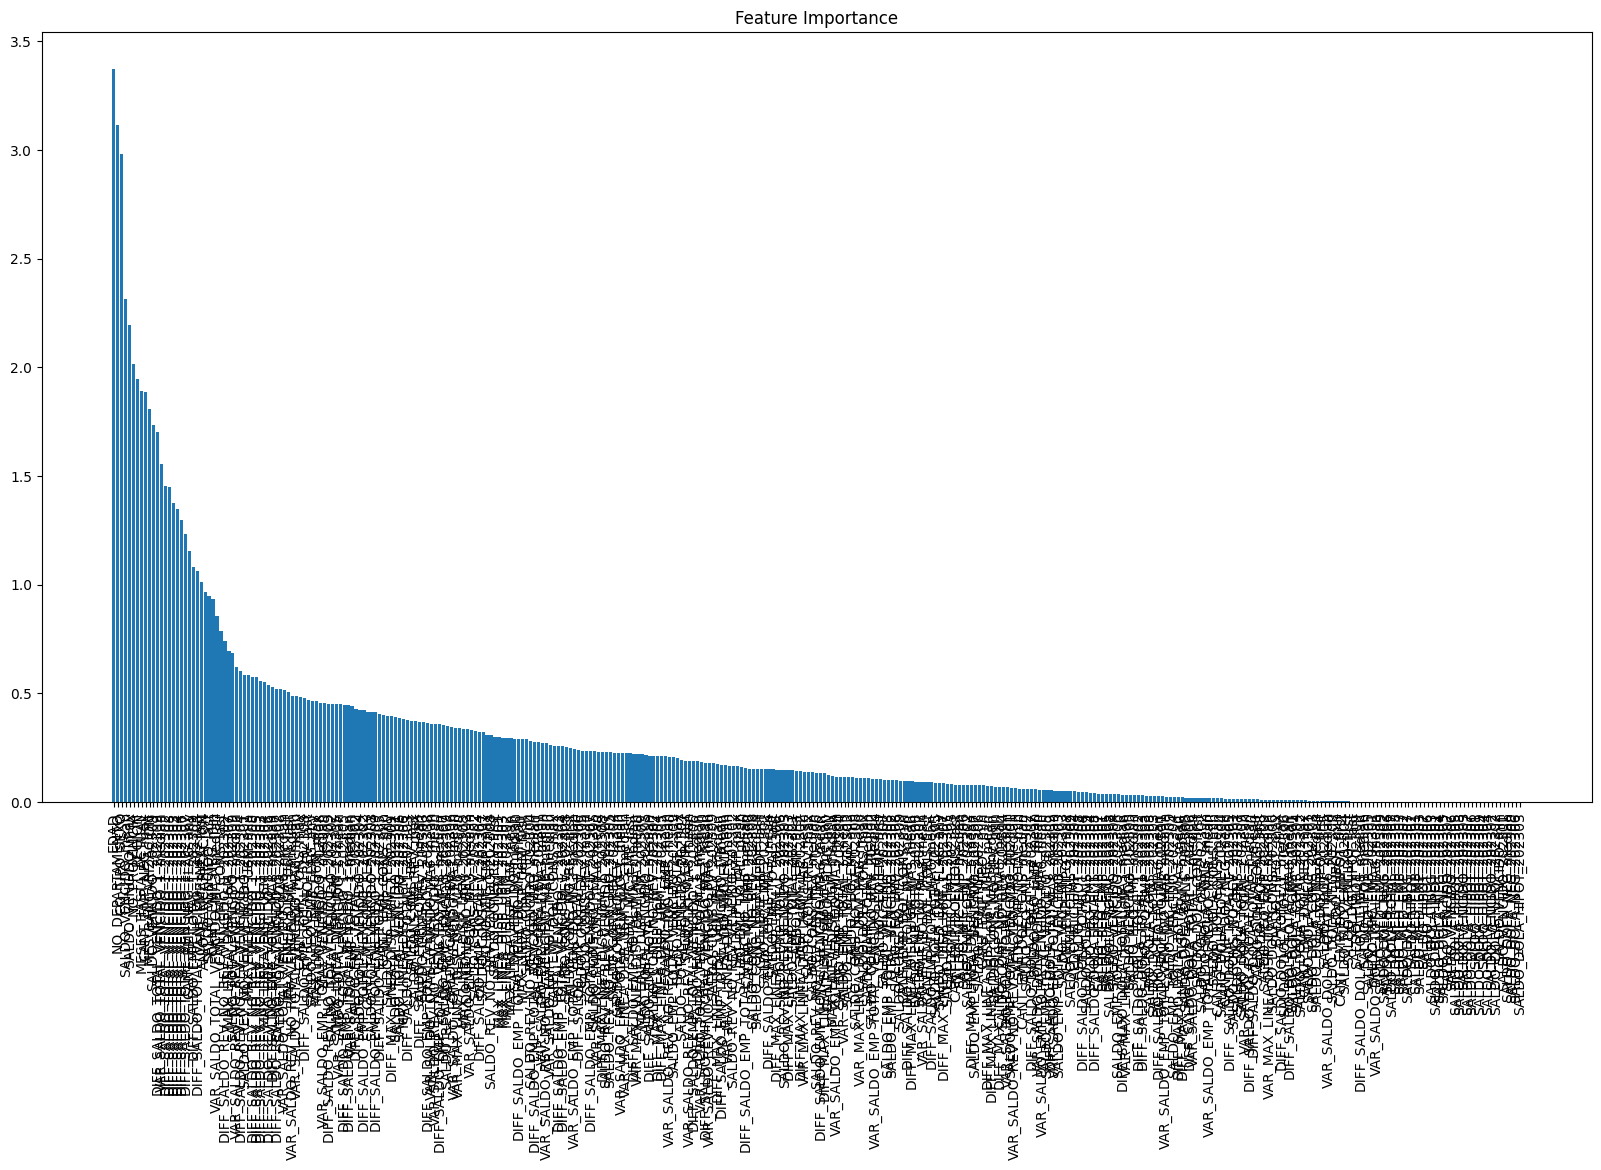

In [28]:
# plot feature importance
plt.figure(figsize=(20, 10))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()

In [29]:
FACTOR = 0.32
data_copy['PRED'] = cat_model.predict_proba(data_copy.drop(columns=[TARGET_VAR]))[:, 1]
data_copy['PRED'] = (data_copy['PRED'] > FACTOR).astype(int)

data_sub['TARGET'] = cat_model.predict_proba(data_sub.drop(columns=[TARGET_VAR]))[:, 1]
data_sub['TARGET'] = (data_sub['TARGET'] > FACTOR).astype(int)

print(classification_report(data_copy[TARGET_VAR], data_copy['PRED']))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     77504
           1       0.77      0.76      0.76     13678

    accuracy                           0.93     91182
   macro avg       0.86      0.86      0.86     91182
weighted avg       0.93      0.93      0.93     91182



In [31]:
submission = pd.concat([data_sub_id, data_sub['TARGET']], axis=1)
print(submission['TARGET'].value_counts(normalize=True))

submission.to_csv('../data/results/catboost_10.csv', index=False)

0   0.852852
1   0.147148
Name: TARGET, dtype: float64
